 # Library declaration 

In [497]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime
from time import process_time 
from sklearn.model_selection import train_test_split

# Data Load

In [498]:
# load all data
df = pd.read_csv('./cases_timeseries_hr.csv', sep=',', header=0, low_memory=False  )
df.columns

Index(['province', 'health_region', 'date_report', 'cases',
       'cumulative_cases'],
      dtype='object')

In [499]:
 df['day']=df['date_report'].str.slice(0, 2)

In [500]:
  df['month'] = df['date_report'].str.slice(3, 5)

In [501]:
  df['year']=df['date_report'].str.slice(6, 10)

In [502]:
 df['case_date']= df['year']+'-'+df['month']+'-'+df['day']

In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32946 entries, 0 to 32945
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   province          32946 non-null  object
 1   health_region     32946 non-null  object
 2   date_report       32946 non-null  object
 3   cases             32946 non-null  int64 
 4   cumulative_cases  32946 non-null  int64 
 5   day               32946 non-null  object
 6   month             32946 non-null  object
 7   year              32946 non-null  object
 8   case_date         32946 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.3+ MB


# Data Preprocessing

In [504]:
# df['date_report']= pd.to_datetime(df['date_report'],  format='%d%m%Y', errors='ignore') 

In [505]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32946 entries, 0 to 32945
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   province          32946 non-null  object
 1   health_region     32946 non-null  object
 2   date_report       32946 non-null  object
 3   cases             32946 non-null  int64 
 4   cumulative_cases  32946 non-null  int64 
 5   day               32946 non-null  object
 6   month             32946 non-null  object
 7   year              32946 non-null  object
 8   case_date         32946 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.3+ MB


In [506]:
len(df)

32946

In [507]:
df

,province,health_region,date_report,cases,cumulative_cases,day,month,year,case_date
0,Alberta,Calgary,25-01-2020,0,0,25,01,2020,2020-01-25
1,Alberta,Calgary,26-01-2020,0,0,26,01,2020,2020-01-26
2,Alberta,Calgary,27-01-2020,0,0,27,01,2020,2020-01-27
3,Alberta,Calgary,28-01-2020,0,0,28,01,2020,2020-01-28
4,Alberta,Calgary,29-01-2020,0,0,29,01,2020,2020-01-29
...,...,...,...,...,...,...,...,...,...
32941,Yukon,Yukon,08-12-2020,1,58,08,12,2020,2020-12-08
32942,Yukon,Yukon,09-12-2020,0,58,09,12,2020,2020-12-09
32943,Yukon,Yukon,10-12-2020,0,58,10,12,2020,2020-12-10
32944,Yukon,Yukon,11-12-2020,0,58,11,12,2020,2020-12-11


In [508]:
df = df.set_index('case_date')

In [509]:
df['province'].value_counts()

Ontario          11305
Quebec            6137
New Brunswick     2584
Saskatchewan      2261
Manitoba          1938
BC                1938
Alberta           1938
NL                1615
Nova Scotia       1615
Nunavut            323
Yukon              323
NWT                323
Repatriated        323
PEI                323
Name: province, dtype: int64

In [510]:
df = df.query('province =="Ontario"')

In [511]:
# df

In [512]:
df_for_cls=df[['cases' ]]

In [513]:
# df_for_cls.query('date_report=="03-12-2020"')

In [514]:
df_for_cls= df_for_cls.groupby(['case_date'])['cases'].sum().reset_index()


In [515]:
# df_for_cls['date_report']= pd.to_datetime(df_for_cls['date_report'],  format='%d%m%Y', errors='ignore') 

In [516]:
df_for_cls = df_for_cls.set_index('case_date')
 

In [517]:
df_for_cls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323 entries, 2020-01-25 to 2020-12-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   323 non-null    int64
dtypes: int64(1)
memory usage: 5.0+ KB


# feature engineering

In [518]:
df_for_cls=df_for_cls[['cases' ]]

In [519]:
# df_for_cls

In [520]:
def create_dataset(dataset):
    dataX,dataY=[],[]
    time_step =7
    for i in range(len(dataset)-time_step):
#         print(i)
        data=[] 
#         data=  [1 if dataset['Hours'][i]==k else 0  for k in range(0,24)]  # One-Hot Encoding
 
 
        load= dataset['cases'][i:(i+time_step)]
        data.extend(list(load))
        
        data.append( dataset['cases'][(i+time_step)])
        label =  dataset['cases'][(i+time_step)] 
#         print(label)

        dataX.append(data)
 
    dX = pd.DataFrame(dataX, columns = [  'load0', 'load1', 'load2', 'load3', 'load4', 'load5', 'load6','label_value'])
#     dY = pd.DataFrame(dataY,  columns = ['label'])
     
    return dX #, dY


 
#     return numpy.array(dataX),numpy.array(dataY)

In [521]:
data_X  = create_dataset(df_for_cls)

In [522]:
# data_X

In [523]:
data_X.to_csv('data/data_X_Without_over_sampling1.csv', index = False) 

In [524]:
data = data_X

In [525]:
# # normalizing input features
# scaler = MinMaxScaler(feature_range=(0, 1))
# data = scaler.fit_transform(data)
# data =pd.DataFrame(data)

In [526]:
X = data.iloc[:,0:7] 
Y = data.iloc[:,7:8]

In [527]:
X

,load0,load1,load2,load3,load4,load5,load6
0,1,0,1,0,0,0,1
1,0,1,0,0,0,1,0
2,1,0,0,0,1,0,0
3,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
311,2049,1813,1537,1935,1744,1928,1983
312,1813,1537,1935,1744,1928,1983,1898
313,1537,1935,1744,1928,1983,1898,1951
314,1935,1744,1928,1983,1898,1951,1947


In [528]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X =pd.DataFrame(X)

In [529]:
X.to_csv('data/X_after_custom_sampling_Without_scaler1.csv', index = False) 
Y.to_csv('data/Y_after_custom_sampling_Without_scaler1.csv', index = False) 

In [530]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle = False, stratify = None)

In [531]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (300, 7)
y_train.shape:  (300, 1)
X_test.shape:  (16, 7)
y_test.shape:  (16, 1)


In [532]:
y_test

,label_value
300,1843
301,1700
302,1595
303,1807
304,2049
305,1813
306,1537
307,1935
308,1744
309,1928


 # Implement  Machine Learning Algorithm

# SVM

In [533]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [534]:
t1_start = process_time()  
SVM = svm.SVR(kernel='sigmoid', C=150,gamma=0.1, epsilon=0.1,).fit(X_train, y_train)
t1_stop = process_time() 
SVM_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         SVM_process_time)  
y_pred  = SVM.predict(X_test)

Elapsed time: 1446.671875 1446.671875
Elapsed time during the whole program in seconds: 0.0


C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [535]:
# score = SVM.score(X_test,y_test)
# print("R-squared:", score)
SVM_MSE  = mean_squared_error(y_test, y_pred, squared=True)
SVM_RMSE  = mean_squared_error(y_test, y_pred, squared=False)

print("MSE:", SVM_MSE)
print("RMSE:", SVM_RMSE)

MSE: 69584.24679934798
RMSE: 263.7882612993762


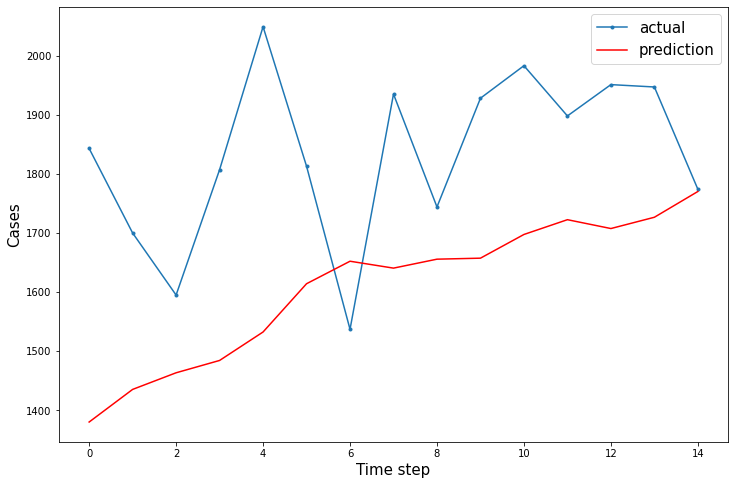

In [536]:
pyplot.figure(figsize=(12,8))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual")
pyplot.plot(aa, y_pred[:15], 'r', label="prediction")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# LogisticRegression

In [537]:
t1_start = process_time()  
LR = LogisticRegression(C=300 ,     random_state=None, solver='newton-cg'  ).fit(X_train, y_train)
t1_stop = process_time() 
LR_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         LR_process_time)  
y_pred = LR.predict(X_test)
# round(LR.score(X_testing,Y_testing), 4)

C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Elapsed time: 1447.875 1446.875
Elapsed time during the whole program in seconds: 1.0


In [538]:
LR_MSE  = mean_squared_error(y_test, y_pred, squared=True)
LR_RMSE  = mean_squared_error(y_test, y_pred, squared=False)

print("MSE:", LR_MSE)
print("RMSE:", LR_RMSE)

MSE: 192345.625
RMSE: 438.5722574445401


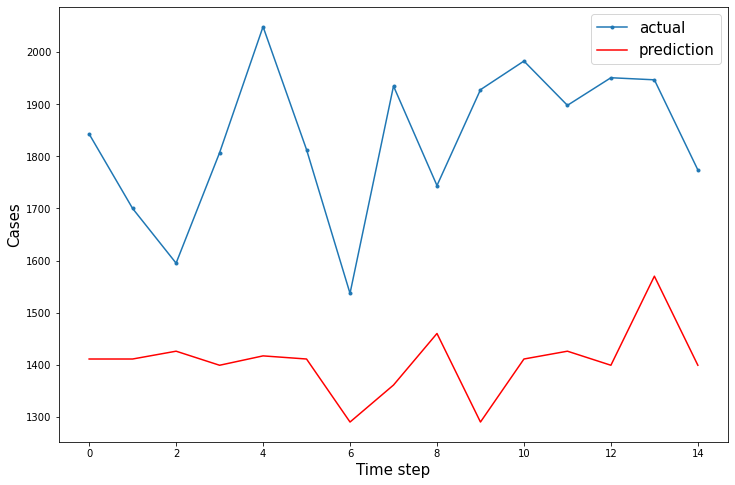

In [539]:
pyplot.figure(figsize=(12,8))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual")
pyplot.plot(aa, y_pred[:15], 'r', label="prediction")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# GradientBoostingRegressor

In [540]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [541]:
t1_start = process_time()
gbr = GradientBoostingRegressor(n_estimators=1000, random_state=0)
gbr.fit(X_train, y_train )
t1_stop = process_time() 
gbr_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         gbr_process_time)  

 

C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Elapsed time: 1449.171875 1448.625
Elapsed time during the whole program in seconds: 0.546875


In [542]:
y_pred = gbr.predict(X_test)

In [543]:
gbr_MSE  = mean_squared_error(y_test, y_pred, squared=True)
gbr_RMSE  = mean_squared_error(y_test, y_pred, squared=False)

print("MSE:", gbr_MSE)
print("RMSE:", gbr_RMSE)

MSE: 140158.58237651782
RMSE: 374.3775933152488


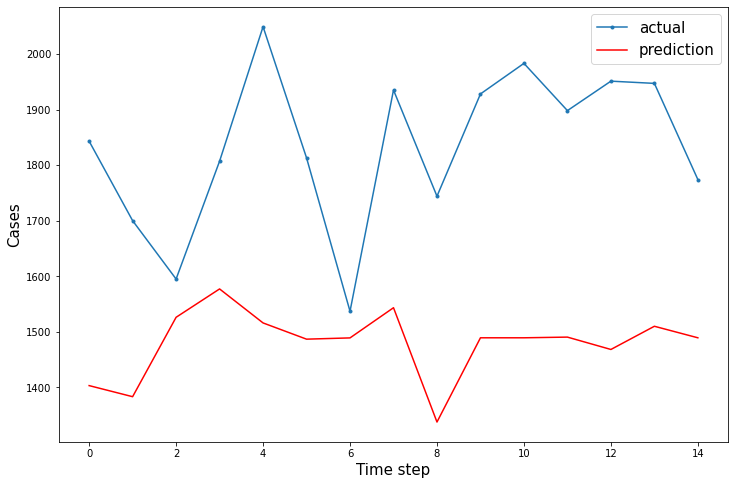

In [544]:
pyplot.figure(figsize=(12,8))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual")
pyplot.plot(aa, y_pred[:15], 'r', label="prediction")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# RandomForestRegressor

In [545]:
t1_start = process_time()
regr = RandomForestRegressor(n_estimators=1000, criterion='mae', max_depth=100 , random_state=0)
regr.fit(X_train, y_train)
t1_stop = process_time() 
regr_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         regr_process_time)  
 

C:\Users\smr99\anaconda3\envs\pd\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Elapsed time: 1454.21875 1449.34375
Elapsed time during the whole program in seconds: 4.875


In [546]:
y_pred = regr.predict(X_test)

In [547]:
regr_MSE  = mean_squared_error(y_test, y_pred, squared=True)
regr_RMSE  = mean_squared_error(y_test, y_pred, squared=False)

print("MSE:", regr_MSE)
print("RMSE:", regr_RMSE)

MSE: 193525.16868918753
RMSE: 439.9149562008406


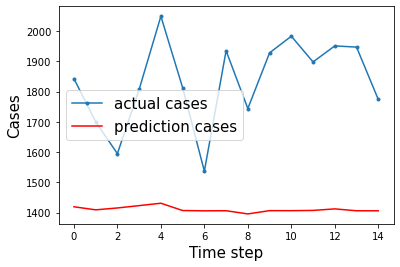

In [548]:
pyplot.figure(figsize=(6,4))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual cases")
pyplot.plot(aa, y_pred[:15], 'r', label="prediction cases")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

In [549]:
X

,0,1,2,3,4,5,6
0,0.000488,0.000000,0.000488,0.000000,0.000000,0.000000,0.000488
1,0.000000,0.000488,0.000000,0.000000,0.000000,0.000488,0.000000
2,0.000488,0.000000,0.000000,0.000000,0.000488,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000488,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000488,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
311,1.000000,0.884822,0.750122,0.944363,0.851147,0.940947,0.967789
312,0.884822,0.750122,0.944363,0.851147,0.940947,0.967789,0.926306
313,0.750122,0.944363,0.851147,0.940947,0.967789,0.926306,0.952172
314,0.944363,0.851147,0.940947,0.967789,0.926306,0.952172,0.950220


In [550]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical
from math import sqrt
from keras.layers import Bidirectional
from keras.layers import  GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

# LSTM

In [551]:
X_train_nn = X_train.values.reshape((X_train.shape[0],   X_train.shape[1],1))
X_test_nn  = X_test.values.reshape((X_test.shape[0],   X_test.shape[1],1))
print(X_train_nn.shape, y_train.shape, X_test_nn.shape, y_test.shape)
 

(300, 7, 1) (300, 1) (16, 7, 1) (16, 1)


In [552]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
y_test1 = scaler.fit_transform(y_test)
y_test1 =pd.DataFrame(y_test1)

In [553]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
y_train1 = scaler1.fit_transform(y_train)
y_train1 =pd.DataFrame(y_train1)

In [577]:
def evaluate_model_lstm(trainX, trainy, testX, testy, epochs=10, batch_size=1,verbose=1):

    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(200, return_sequences=True,input_shape=(n_timesteps, n_features)))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(n_outputs ))
    model.compile(loss='mae', optimizer='adam' )
    # fit network
    model_history = model.fit(trainX, trainy, epochs=epochs,  batch_size=batch_size, verbose=verbose,  shuffle=False)
 
    return model,model_history

In [578]:
t1_start = process_time()
model_lstm, model_history  = evaluate_model_lstm(X_train_nn,y_train1,X_test_nn,y_test1)

t1_stop = process_time() 
model_lstm_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                         model_lstm_process_time) 

Epoch 1/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0530
Epoch 2/10
300/300 [==============================] - 2s 6ms/step - loss: 0.1010
Epoch 3/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0782
Epoch 4/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0629
Epoch 5/10
300/300 [==============================] - 2s 6ms/step - loss: 0.0615
Epoch 6/10
300/300 [==============================] - 2s 6ms/step - loss: 0.0580
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0564
Epoch 8/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0567
Epoch 9/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0539
Epoch 10/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0563
Elapsed time: 1649.34375 1577.15625
Elapsed time during the whole program in seconds: 72.1875


In [556]:
# pyplot.plot(model_history.history['loss'], label='LSTM train', color='red')
# pyplot.plot(model_history.history['val_loss'], label='LSTM test', color= 'green')

# pyplot.legend()
# pyplot.show()

In [557]:
yhat_test = model_lstm.predict(X_test_nn)


In [558]:
yhat_test11 = scaler.inverse_transform(yhat_test)

In [560]:
lstm_MSE  = mean_squared_error(y_test, yhat_test11, squared=True)
lstm_RMSE  = mean_squared_error(y_test, yhat_test11, squared=False)

print("MSE:", lstm_MSE)
print("RMSE:", lstm_RMSE)

MSE: 78267.92129356507
RMSE: 279.76404574849334


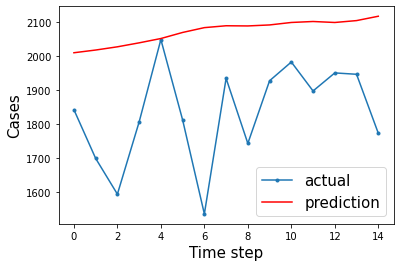

In [561]:
pyplot.figure(figsize=(6,4))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual")
pyplot.plot(aa, yhat_test11[:15], 'r', label="prediction")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# Conv1D_LSTM

In [562]:
def evaluate_model_Conv1D_LSTM(trainX, trainy, testX, testy,  epochs=10, batch_size=1,verbose=1):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(100, kernel_size=3, activation = 'relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(50))
    model.add(Dense(n_outputs ))
    model.compile(loss='mae', optimizer='adam' )
 
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

     
    return model

In [563]:
t1_start = process_time()
Conv1D_LSTM_model  = evaluate_model_Conv1D_LSTM(X_train_nn,y_train1,X_test_nn,y_test1)
t1_stop = process_time() 
Conv1D_LSTM_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                       Conv1D_LSTM_process_time) 

Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0662
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0480
Epoch 3/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0402
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0461
Epoch 5/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0407
Epoch 6/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0410
Epoch 7/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0410
Epoch 8/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0400
Epoch 9/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0379
Epoch 10/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0382
Elapsed time: 1572.265625 1531.046875
Elapsed time during the whole program in seconds: 41.21875


In [564]:
yhat_test2 = Conv1D_LSTM_model.predict(X_test_nn)

In [565]:
yhat_test3 = scaler.inverse_transform(yhat_test2)

In [566]:
Conv1D_LSTM_MSE  = mean_squared_error(y_test, yhat_test3, squared=True)
Conv1D_LSTM_RMSE  = mean_squared_error(y_test, yhat_test3, squared=False)

print("MSE:", Conv1D_LSTM_MSE)
print("RMSE:", Conv1D_LSTM_RMSE)

MSE: 79560.1455868911
RMSE: 282.0640806392957


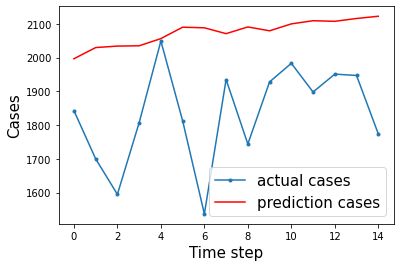

In [567]:
pyplot.figure(figsize=(6,4))
aa=[x for x in range(15)]
pyplot.plot(aa, y_test[:15], marker='.', label="actual cases")
pyplot.plot(aa, yhat_test3[:15], 'r', label="prediction cases")
pyplot.ylabel('Cases', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

# Conv1D

In [568]:

# fit and evaluate a model
def evaluate_model_Conv1D(trainX, trainy, testX, testy,  epochs=10, batch_size=1,verbose=1):
 
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=200, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
  
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(n_outputs ))
    model.compile(loss='mae', optimizer='adam' )
#     model.summary()
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

     
    return model

In [569]:
Conv1D_model  = evaluate_model_Conv1D(X_train_nn,y_train1,X_test_nn,y_test1)

Epoch 1/10
300/300 [==============================] - 0s 991us/step - loss: 0.0489
Epoch 2/10
300/300 [==============================] - 0s 704us/step - loss: 0.0404
Epoch 3/10
300/300 [==============================] - 0s 685us/step - loss: 0.0410
Epoch 4/10
300/300 [==============================] - 0s 783us/step - loss: 0.0399
Epoch 5/10
300/300 [==============================] - 0s 1ms/step - loss: 0.0386
Epoch 6/10
300/300 [==============================] - 0s 811us/step - loss: 0.0385
Epoch 7/10
300/300 [==============================] - 0s 888us/step - loss: 0.0384
Epoch 8/10
300/300 [==============================] - 0s 841us/step - loss: 0.0387
Epoch 9/10
300/300 [==============================] - 0s 721us/step - loss: 0.0378
Epoch 10/10
300/300 [==============================] - 0s 824us/step - loss: 0.0392


In [570]:
t1_start = process_time()
yhat_test5 = Conv1D_model.predict(X_test_nn)
t1_stop = process_time() 
Conv1D_process_time=  t1_stop-t1_start
print("Elapsed time:", t1_stop, t1_start)  
print("Elapsed time during the whole program in seconds:", 
                                       Conv1D_LSTM_process_time) 

Elapsed time: 1576.46875 1576.421875
Elapsed time during the whole program in seconds: 41.21875


In [571]:
yhat_test56 = scaler.inverse_transform(yhat_test5)

In [572]:
Conv1D_MSE  = mean_squared_error(y_test, yhat_test56, squared=True)
Conv1D_RMSE  = mean_squared_error(y_test, yhat_test56, squared=False)

print("MSE:", Conv1D_MSE)
print("RMSE:", Conv1D_RMSE)

MSE: 107154.60396610573
RMSE: 327.34477843109966


 # Result Comparing

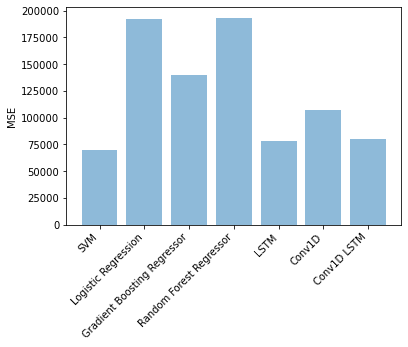

In [573]:
import matplotlib.pyplot as plt;  import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

objects = ('SVM', 'Logistic Regression', 'Gradient Boosting Regressor', 'Random Forest Regressor', 'LSTM', 'Conv1D', 'Conv1D LSTM' )
y_pos = np.arange(len(objects))
performance = [SVM_MSE, LR_MSE, gbr_MSE, regr_MSE, lstm_MSE, Conv1D_MSE, Conv1D_LSTM_MSE]
fig = plt.figure(figsize=(6, 4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('MSE')
 
plt.xticks(rotation=45, ha='right')
plt.show()
fig.savefig('images/MSE.pdf')

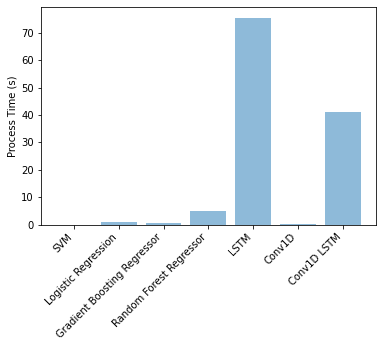

In [576]:
import matplotlib.pyplot as plt;  import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

objects = ('SVM', 'Logistic Regression', 'Gradient Boosting Regressor', 'Random Forest Regressor', 'LSTM', 'Conv1D', 'Conv1D LSTM' )
y_pos = np.arange(len(objects))
performance = [SVM_process_time, LR_process_time, gbr_process_time, regr_process_time, model_lstm_process_time, Conv1D_process_time, Conv1D_LSTM_process_time ]
fig = plt.figure(figsize=(6, 4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Process Time (s)')
 
plt.xticks(rotation=45, ha='right')
plt.show()
fig.savefig('images/RMSE.pdf')

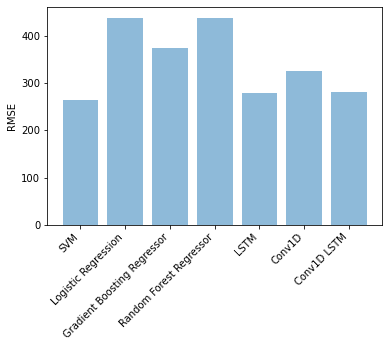

In [575]:
import matplotlib.pyplot as plt;  import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

objects = ('SVM', 'Logistic Regression', 'Gradient Boosting Regressor', 'Random Forest Regressor', 'LSTM', 'Conv1D', 'Conv1D LSTM' )
y_pos = np.arange(len(objects))
performance = [SVM_RMSE, LR_RMSE, gbr_RMSE, regr_RMSE, lstm_RMSE, Conv1D_RMSE, Conv1D_LSTM_RMSE ]
fig = plt.figure(figsize=(6, 4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
 
plt.xticks(rotation=45, ha='right')
plt.show()
fig.savefig('images/RMSE.pdf')